In [1]:
import sionna

import tensorflow as tf
tf.random.set_seed(1) # Set global random seed for reproducibility
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [2]:
scene = load_scene("cape_town/cape_town.xml")

from plyfile import PlyData

def load_ply(filename):

    ply_data = PlyData.read(filename)
    
    # Extract vertex coordinates
    vertices = np.vstack([ply_data['vertex'][dim] for dim in ['x', 'y', 'z']]).T

    # Extract face indices
    faces = [face[0] for face in ply_data['face']['vertex_indices']]
    
    return vertices, faces

# Usage example
vertices, faces = load_ply('cape_town/meshes/14_Loop_Street-itu_marble.ply')

print("Vertices:\n", vertices)
print("Faces:\n", faces)

In [86]:
#cam = Camera("my_cam", position=(-100,150,150))
#scene.add(cam)
#cam.look_at([0,0,0])
#scene.render(cam);

In [87]:
scene.frequency = 3.5e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
# Place a transmitter
tx = Transmitter("tx", position=[-92,3,33], look_at=[0,0,0])
scene.add(tx)

rx = Receiver("rx", position=[-77,-40,1.5])
rx1 = Receiver("rx1", position=[-31,-41,1.5])
scene.add(rx)
scene.add(rx1)
# RIs
ris = RIS(name="ris",
          position=[-20,-15,40],
          orientation=[PI/4-PI,0,0],
          num_rows=100,
          num_cols=100,
          num_modes=2,)
scene.add(ris)
tx.look_at(ris)

sources = [tx.position, tx.position]
targets = [rx.position, rx1.position]
ris.phase_gradient_reflector(sources, targets)

In [88]:
target_center = np.array([-77,-40,1.5]) # Center
target_size = np.array([10.,10.]) # Size
cm_cell_size = [1, 1]  # Cell size of the coverage map
cm_center = np.array([-60, -10, 1.5])  # Center of the coverage map
cm_size = np.array([150, 150])  # Size of the coverage map
target_center2 = np.array([-31,-41,1.5]) # Center
target_size2 = np.array([10.,10.]) # Size

In [89]:
cm_no_ris = scene.coverage_map(num_samples=10e6, #increase for better resolution
                        max_depth=6,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        scattering=True,
                        ris=False,
                        cm_cell_size=[1,1],
                        cm_orientation=[0,0,0],
                        cm_center=cm_center,
                        cm_size=cm_size, check_scene=False)

In [90]:
m1 = tf.Variable([0.1, 0.9], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))

In [91]:
optimizer = tf.keras.optimizers.Adam(0.005)

In [92]:
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)

In [93]:
num_steps = 100

def train_step():
    """A single training step"""
    with tf.GradientTape() as tape:
        ris.amplitude_profile.mode_powers = m1 / tf.reduce_sum(m1)
        # Compute coverage of the target area
        target_cm = scene.coverage_map(num_samples=10e6, #increase for better resolution
                                       max_depth=6, 
                                       cm_center=target_center,
                                       cm_orientation=[0,0,0], 
                                       cm_size=target_size, # Target area 
                                       cm_cell_size=cm_cell_size,
                                       diffraction=True, scattering=True, ris=True, # Enable diffraction and scattering in addition to reflection and LoS
                                       check_scene=False) # Don't check the scene prior to compute to speed things up
        # The loss function is a rate in bit
        target_cm2 = scene.coverage_map(num_samples=10e6, #increase for better resolution
                                       max_depth=6, 
                                       cm_center=target_center2,
                                       cm_orientation=[0,0,0], 
                                       cm_size=target_size2, # Target area 
                                       cm_cell_size=cm_cell_size,
                                       diffraction=True, scattering=True, ris=True, # Enable diffraction and scattering in addition to reflection and LoS
                                       check_scene=False)
        # We fix an arbitrary scaling factor corresponding to the transmit to noise power ratio
        # The scaling has a direct impact the gradient magnitudes
        #scaling = 1e6
        path_gain1 = to_db(tf.reduce_mean(target_cm.as_tensor()))
        path_gain2 = to_db(tf.reduce_mean(target_cm2.as_tensor()))
        loss = tf.abs(path_gain1 - path_gain2) 
    
    # Compute gradients and apply through the optimizer
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return path_gain1, path_gain2
path_gain1_list = []
path_gain2_list = []


for step in range(num_steps):       
    path_gain1, path_gain2 = train_step()
    path_gain1_list.append(path_gain1.numpy())
    path_gain2_list.append(path_gain2.numpy())
    print(f"Training step {step} - Rate: {path_gain1.numpy():.2f}dB, Path gain 2: {path_gain2.numpy():.2f}dB - Amplitude values: {m1 / tf.reduce_sum(m1).numpy()}")

Training step 0 - Rate: -104.54dB, Path gain 2: -89.96dB - Amplitude values: [0.10499997 0.89500004]
Training step 1 - Rate: -104.48dB, Path gain 2: -90.06dB - Amplitude values: [0.10999484 0.8900052 ]
Training step 2 - Rate: -103.50dB, Path gain 2: -90.12dB - Amplitude values: [0.11499798 0.885002  ]
Training step 3 - Rate: -102.84dB, Path gain 2: -90.14dB - Amplitude values: [0.12000754 0.8799925 ]
Training step 4 - Rate: -103.41dB, Path gain 2: -90.21dB - Amplitude values: [0.12500374 0.87499624]
Training step 5 - Rate: -102.91dB, Path gain 2: -90.24dB - Amplitude values: [0.12999272 0.8700073 ]
Training step 6 - Rate: -102.45dB, Path gain 2: -90.21dB - Amplitude values: [0.13497646 0.86502355]
Training step 7 - Rate: -102.18dB, Path gain 2: -90.37dB - Amplitude values: [0.13995287 0.8600471 ]
Training step 8 - Rate: -102.17dB, Path gain 2: -90.43dB - Amplitude values: [0.14491665 0.85508335]
Training step 9 - Rate: -101.65dB, Path gain 2: -90.46dB - Amplitude values: [0.14987108 0.

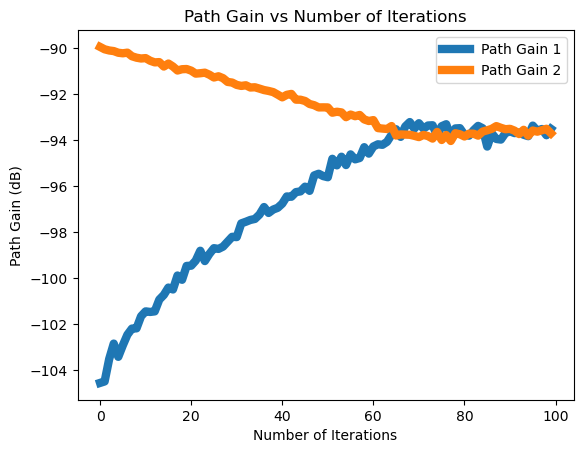

In [108]:
fig1 = plt.figure()
plt.plot(range(num_steps), path_gain1_list, label='Path Gain 1', linewidth=6)
plt.plot(range(num_steps), path_gain2_list, label='Path Gain 2', linewidth=6)
plt.xlabel('Number of Iterations')
plt.ylabel('Path Gain (dB)')
plt.title('Path Gain vs Number of Iterations')
plt.legend()
plt.show()
fig1.savefig('iteration1.png', dpi=600, bbox_inches='tight')

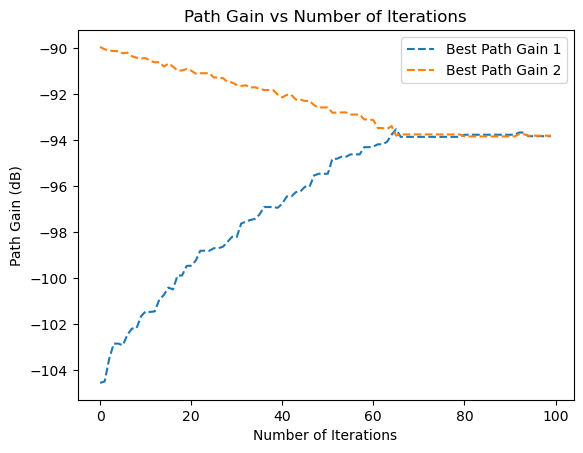

In [95]:
path_gain1_list
path_gain2_list
num_steps = len(path_gain1_list)

# Calculate the loss (absolute difference) at each iteration
loss_list = [abs(p1 - p2) for p1, p2 in zip(path_gain1_list, path_gain2_list)]

# Initialize variables to track the best observed results
best_loss = float('inf')
best_path_gain1_list = []
best_path_gain2_list = []

# Track the best observed results
for i in range(num_steps):
    if loss_list[i] < best_loss:
        best_loss = loss_list[i]
        best_path_gain1 = path_gain1_list[i]
        best_path_gain2 = path_gain2_list[i]
    best_path_gain1_list.append(best_path_gain1)
    best_path_gain2_list.append(best_path_gain2)

# Plot the results


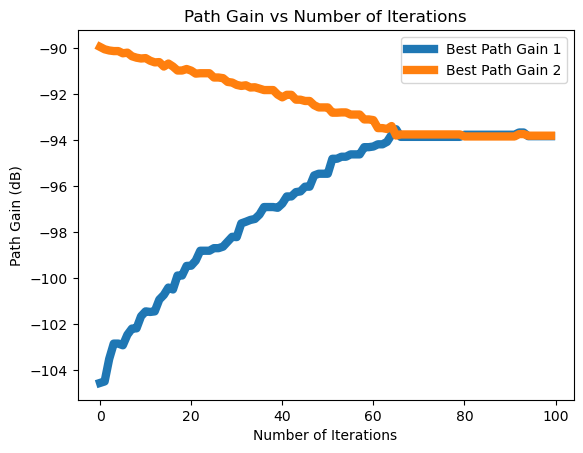

In [110]:
fig2 = plt.figure()
plt.plot(range(num_steps), best_path_gain1_list, label='Best Path Gain 1', linewidth=6)
plt.plot(range(num_steps), best_path_gain2_list, label='Best Path Gain 2', linewidth=6)
plt.xlabel('Number of Iterations')
plt.ylabel('Path Gain (dB)')
plt.title('Path Gain vs Number of Iterations')
plt.legend()
plt.show()
fig2.savefig('bestiteration1.png', dpi=600, bbox_inches='tight')

In [96]:
cm_new = scene.coverage_map(num_samples=10e6, #increase for better resolution
                        max_depth=6,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        scattering=True,
                        ris=True,
                        cm_cell_size=[1,1],
                        cm_orientation=[0,0,0],
                        cm_center=cm_center,
                        cm_size=cm_size, check_scene=False)

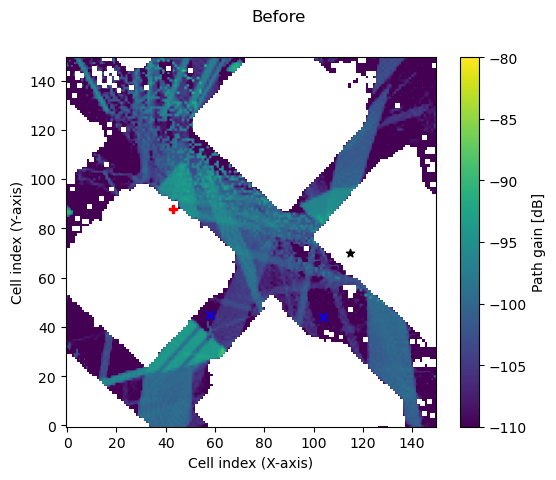

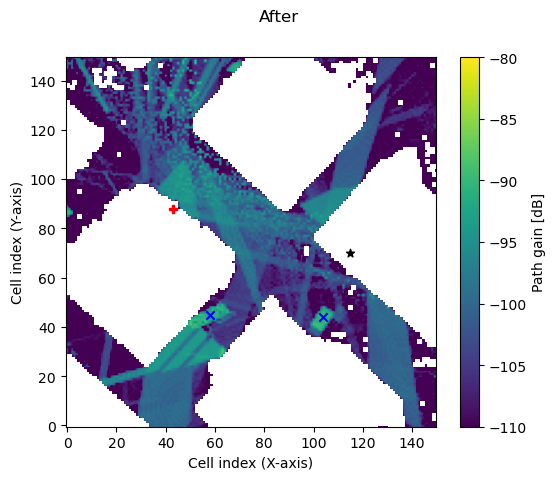

In [160]:

fig3 = cm_no_ris.show(vmin=-110, vmax=-80, show_ris=True, show_rx=True)
fig3.suptitle("Before")
fig3.savefig('CMbefore.png', dpi=600, bbox_inches='tight')

# Display the optimized coverage map
fig4 = cm_new.show(vmin=-110, vmax=-80, show_ris=True, show_rx=True)
fig4.suptitle("After")
fig4.savefig('CMafter.png', dpi=600, bbox_inches='tight')

C:\Users\mjava\AppData\Local\Temp\ipykernel_9840\4105211170.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cm_new._value[0]/cm_no_ris._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)


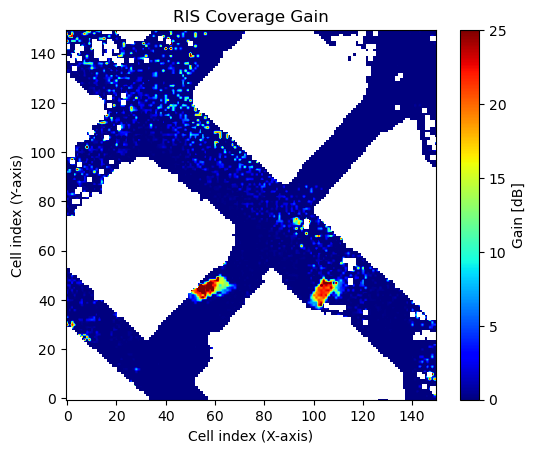

In [114]:
colormaps = ['jet']
for cmap in colormaps:
    fig5 = plt.figure()
    plt.imshow(10*np.log10(cm_new._value[0]/cm_no_ris._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)
    plt.colorbar(label='Gain [dB]')
    plt.xlabel('Cell index (X-axis)');
    plt.ylabel('Cell index (Y-axis)');
    plt.title("RIS Coverage Gain");
    fig5.savefig('Gain.png', dpi=1200, bbox_inches='tight')

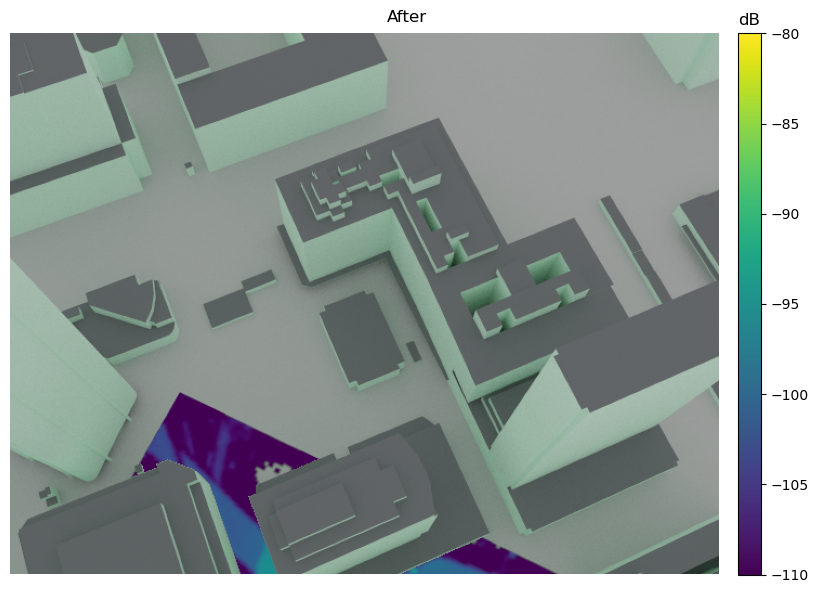

In [159]:
# Add a camera for viewing the scene from the sky
cam = Camera("my_camq111", position=(-30,-30,300))
scene.add(cam)
cam.look_at([75,20,0])

# Rendering with the unoptimized orientation
#fig = scene.render("my_cam21", coverage_map=cm_no_ris, cm_vmin=-110, cm_vmax=-80)
#fig.suptitle("Before")

# Rendering with the optimized orientation
fig = scene.render("my_camq111", coverage_map=cm_new, cm_vmin=-110, cm_vmax=-80)
fig.suptitle("After");